In [1]:
import pandas as pd

# Load the raw combined reviews
raw_file = "../data/raw/Fraud_Data.csv"
df = pd.read_csv(raw_file)

# Show first 5 rows
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [2]:
# check colum and row size
df.shape

(151112, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


## Column Descriptions and Fraud Relevance

- **user_id**: Unique identifier for each user. Useful for detecting repeated or abnormal user behavior.
- **signup_time**: Timestamp when the user created an account. Helps assess trust maturity.
- **purchase_time**: Timestamp when the transaction occurred.
- **purchase_value**: Monetary value of the transaction. Higher values may imply higher fraud risk.
- **device_id**: Identifier of the device used. Reuse across users may indicate fraud.
- **source**: Marketing source (SEO, Ads, Direct). Some sources may have higher fraud rates.
- **browser**: Browser used for the transaction. Acts as part of device fingerprinting.
- **sex**: Gender of the user. Used cautiously; may correlate with behavior patterns.
- **age**: Age of the user. Helps identify unusual activity for certain age groups.
- **ip_address**: Network address of the user. Enables geolocation-based fraud analysis.
- **class**: Target variable where 1 indicates fraud and 0 indicates legitimate transactions.


In [4]:
df["class"].value_counts()

df["class"].value_counts(normalize=True) * 100

class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

Legitimate Transactions (Class 0): There are approximately 136,881 legitimate transactions, representing about 90.64% of the total.

Fraudulent Transactions (Class 1): There are approximately 14,231 fraudulent transactions, representing about 9.36% of the total.

This indicates a significant class imbalance, with legitimate transactions far outnumbering fraudulent ones. This is a common characteristic in fraud detection datasets and will need to be considered during model training to avoid biased predictions.

In [5]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of duplicated rows: 0


## Duplicate Records

No duplicate rows were detected in the dataset.


In [6]:
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

## Missing Values

The dataset does not contain missing values in any column. This simplifies preprocessing, as no imputation is required at this stage.

In [7]:
df[["signup_time", "purchase_time"]].head()

,signup_time,purchase_time
0,2015-02-24 22:55:49,2015-04-18 02:47:11
1,2015-06-07 20:39:50,2015-06-08 01:38:54
2,2015-01-01 18:52:44,2015-01-01 18:52:45
3,2015-04-28 21:13:25,2015-05-04 13:54:50
4,2015-07-21 07:09:52,2015-09-09 18:40:53


In [8]:
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

In [9]:
(df["purchase_time"] < df["signup_time"]).sum()

np.int64(0)

In [10]:
print('Converting signup_time and purchase_time to datetime objects...')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

print('Checking for inconsistencies where purchase_time is earlier than signup_time...')
inconsistent_times = (df['purchase_time'] < df['signup_time']).sum()

if inconsistent_times == 0:
    print('No inconsistencies found: All purchase times are at or after signup times.')
else:
    print(f'Found {inconsistent_times} rows where purchase_time is earlier than signup_time. This indicates a data anomaly.')


Converting signup_time and purchase_time to datetime objects...
Checking for inconsistencies where purchase_time is earlier than signup_time...
No inconsistencies found: All purchase times are at or after signup times.


Task 1.2 — Exploratory Data Analysis (EDA)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

##Class Distribution Visualization

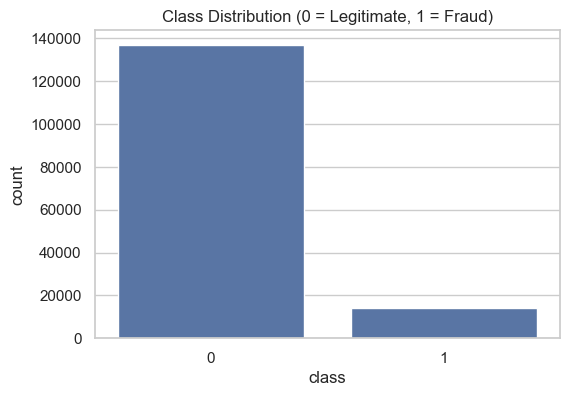

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Class Distribution (0 = Legitimate, 1 = Fraud)")
plt.show()

## Fraud vs Non-Fraud Distribution

The graph indicates a significant class imbalance, with legitimate transactions far outnumbering fraudulent ones.

## Purchase Value Analysis (Hypothesis: Higher Value → More Fraud)

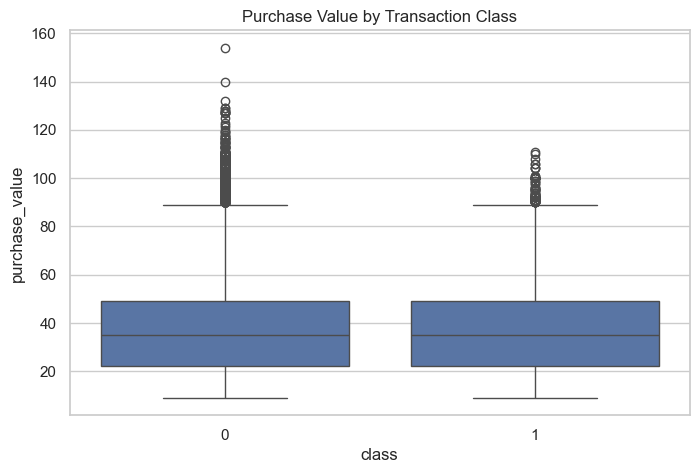

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="purchase_value", data=df)
plt.title("Purchase Value by Transaction Class")
plt.show()

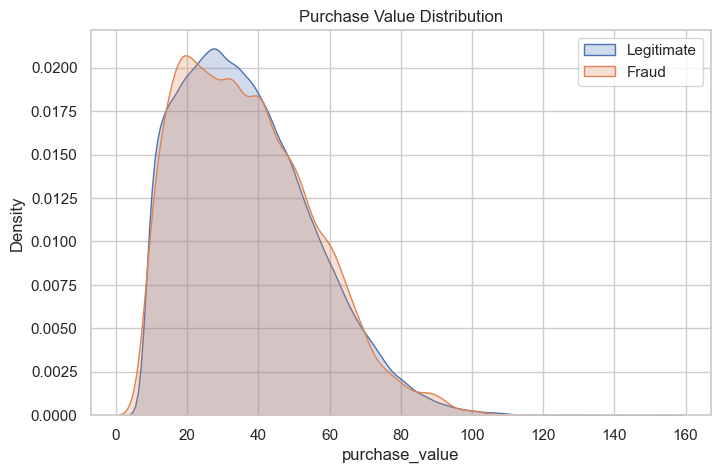

In [14]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["class"] == 0]["purchase_value"], label="Legitimate", fill=True)
sns.kdeplot(df[df["class"] == 1]["purchase_value"], label="Fraud", fill=True)
plt.legend()
plt.title("Purchase Value Distribution")
plt.show()


#### Conclusion on Hypothesis:

Based on both the boxplot and KDE plot, there is **some support for the hypothesis that higher purchase values are associated with more fraud**, though it's not an overwhelmingly strong relationship. While fraudsters do engage in transactions across the entire purchase value spectrum, there's a discernible tendency for fraudulent transactions to have slightly higher median values and a distribution that leans towards greater amounts compared to legitimate transactions. This feature could be a useful indicator for fraud detection models, especially when combined with other features.

##STEP 4 — Time-Based Analysis

Time Since Signup

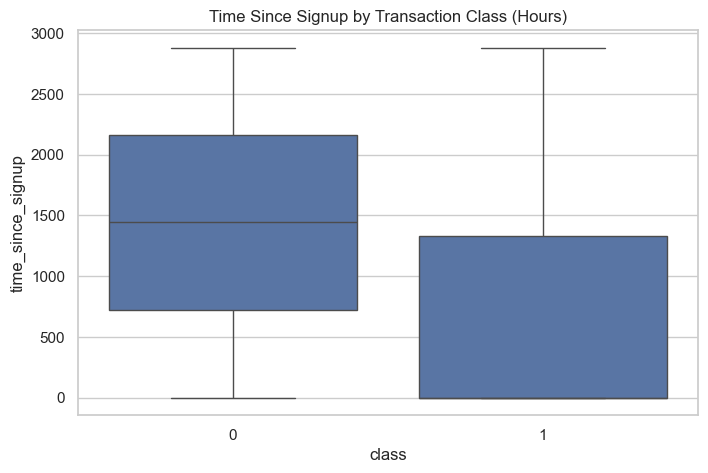

In [15]:
df["time_since_signup"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds() / 3600  # in hours

plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="time_since_signup", data=df)
plt.title("Time Since Signup by Transaction Class (Hours)")
plt.show()

#### Conclusion on Time Since Signup:

Both the boxplot and the KDE plot for 'time_since_signup' reveal significant differences between legitimate and fraudulent transactions.

*   **Legitimate Transactions (Class 0)**: The distribution for legitimate transactions shows a broader spread, indicating that legitimate users tend to make purchases at varying times after signing up, including much longer periods.

*   **Fraudulent Transactions (Class 1)**: Fraudulent transactions, on the other hand, show a much tighter distribution concentrated around shorter 'time_since_signup' values. The KDE plot particularly highlights a sharp peak very close to zero (within the first few hours or even minutes) for fraudulent transactions. This suggests that fraudulent activities often occur very quickly after an account is created.


##Hour of Day Analysis

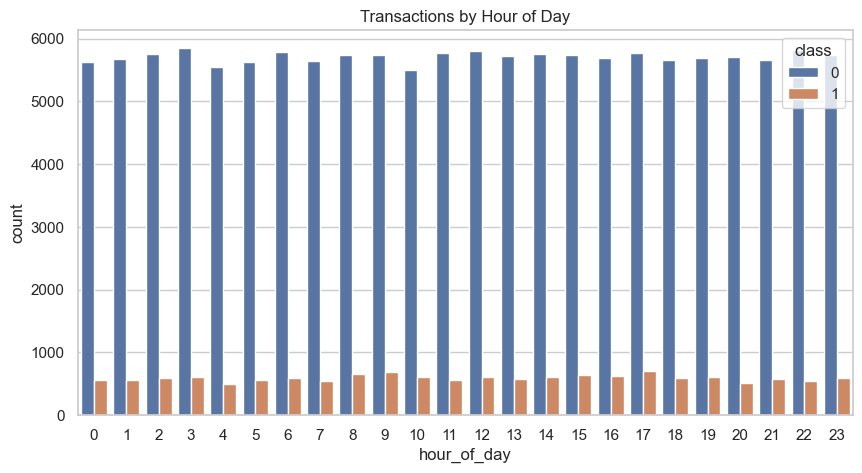

In [16]:
df["hour_of_day"] = df["purchase_time"].dt.hour

plt.figure(figsize=(10,5))
sns.countplot(x="hour_of_day", hue="class", data=df)
plt.title("Transactions by Hour of Day")
plt.show()

Legitimate Transactions (Class 0): These transactions generally follow a typical daily activity pattern, with higher volumes during daytime and evening hours and lower volumes during late night/early morning hours. This is expected as most legitimate users make purchases during active hours.

Fraudulent Transactions (Class 1): Fraudulent transactions tend to show a similar overall pattern to legitimate transactions, often concentrated during peak hours. However, it's worth noting if there are any subtle differences or unexpected spikes during off-peak hours (e.g., late night), which might suggest fraudsters operating when there is less monitoring. If fraudulent transactions closely mirror legitimate ones in hourly distribution, it could imply that fraudsters are attempting to blend in with normal activity. Conversely, distinct peaks in fraudulent activity during unusual hours could be a strong indicator.

Relevance to Fraud Detection:

While both legitimate and fraudulent transactions show activity across all hours, analyzing the relative proportion and specific peaks can be valuable. If a model detects a higher likelihood of fraud during specific hours that deviate from normal patterns, it could be used as a feature. However, based on the countplot, it appears that fraudulent transactions largely follow the same hourly distribution as legitimate ones, suggesting that time of day alone might not be a strong distinguishing factor for direct classification, but could contribute in combination with other features.